Імпортування необхідних бібліотек для побудови моделі ARIMA:
Pandas, numpy, statsmodel 


In [2]:
import os
from pandas import read_csv, DataFrame
import numpy as np
import statsmodels.api as sm
from statsmodels.iolib.table import SimpleTable
from statsmodels.tsa.arima.model import ARIMA

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from plotly import __version__
from plotly import graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot
from sklearn.metrics import r2_score

init_notebook_mode(connected=True)

#from sklearn.metrics import r2_score
#import ml_metrics as metrics
def plotly_df(df, title=""):
    data = []

    for column in df.columns:
        trace = go.Scatter(x=df.index, y=df[column], mode="lines", name=column)
        data.append(trace)

    layout = dict(title=title)
    fig = dict(data=data, layout=layout)
    iplot(fig, show_link=False)

c:\python virtual envs\time series\lib\site-packages\statsmodels\compat\pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


Зчитування данних. Із файлу із статистикою переглядів постів

In [3]:
# read file with goods
view_statistics = read_csv('./Data/views.csv',';', index_col=['date'], parse_dates=['date'], dayfirst=True)
view_statistics.head(10)

c:\python virtual envs\time series\lib\site-packages\IPython\core\interactiveshell.py:3251: FutureWarning:

In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.



,qty
date,
2017-09-01,179667
2017-09-02,177670
2017-09-03,152112
2017-09-04,142938
2017-09-05,130741
2017-09-06,195866
2017-09-07,162560
2017-09-08,175382
2017-09-09,139323


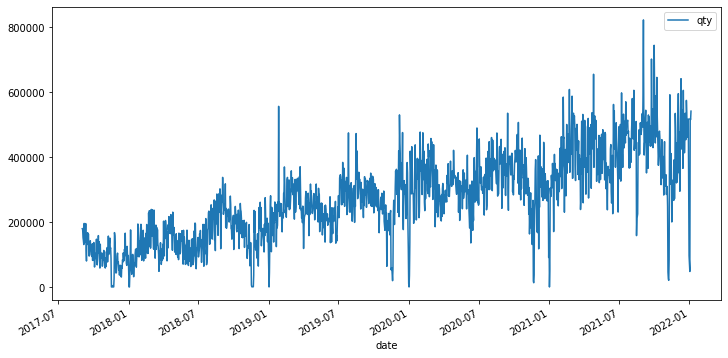

In [4]:
view_statistics.plot(figsize=(12,6))
plotly_df(view_statistics, title="views")

З графіку видно, що ряд має викиди. Аналізувати перегляди за кожен день не зовсім правильно, наприкінці або на початку тижня будуть дні в які переглядів більше, ніж в інші. Тому є сенс перейти до тижневого інтервалу та середнього значення переглядів на ньому. Перехід до тижневого інтервалу позбавить дані викидів і зменшить коливання ряду. в бібліотеці pandas для цього є функція resample(), як параметри їй передається період округлення, після чого, виконується агрегаційна функція. Вибираємо в якості агрегаційної функції 'медіану' для того, щоб позбутися викидів.

In [5]:
view_statistics_weekly_median_aggregated = view_statistics.resample('W').median() 
view_statistics_weekly_mean_aggregated = view_statistics.resample('W').mean()
view_statistics_weekly_sum_aggregated = view_statistics.resample('W').sum()

data_week_resampled = view_statistics_weekly_mean_aggregated
data = data_week_resampled

Порівняння графіків тижневих інтервалів з різними агрегуючими функціями: медіана, середнє, сума.

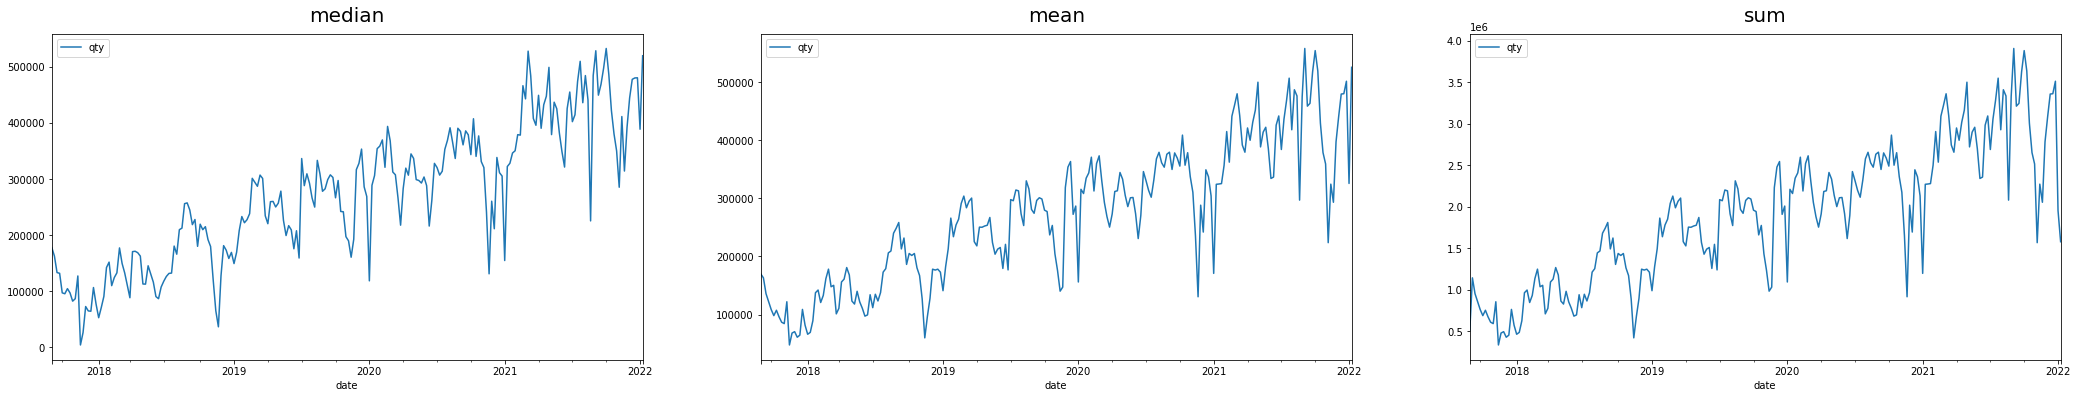

In [6]:
#figure(figsize=(24,6))
fig, axes = plt.subplots(ncols=3, figsize=(36,6))

title_fontsize = {'fontsize': 20}
title_padding = 12

axes[0].set_title('median', fontdict=title_fontsize, pad=title_padding)
axes[1].set_title('mean', fontdict=title_fontsize, pad=title_padding)
axes[2].set_title('sum', fontdict=title_fontsize, pad=title_padding)

view_statistics_weekly_median_aggregated.plot(ax = axes[0], subplots=True)
view_statistics_weekly_mean_aggregated.plot(ax = axes[1], subplots=True)
view_statistics_weekly_sum_aggregated.plot(ax = axes[2], subplots=True)

plt.show()

plotly_df(data, title="views")

In [7]:
type(view_statistics_weekly_mean_aggregated)
axes[0]

<AxesSubplot:title={'center':'median'}, xlabel='date'>

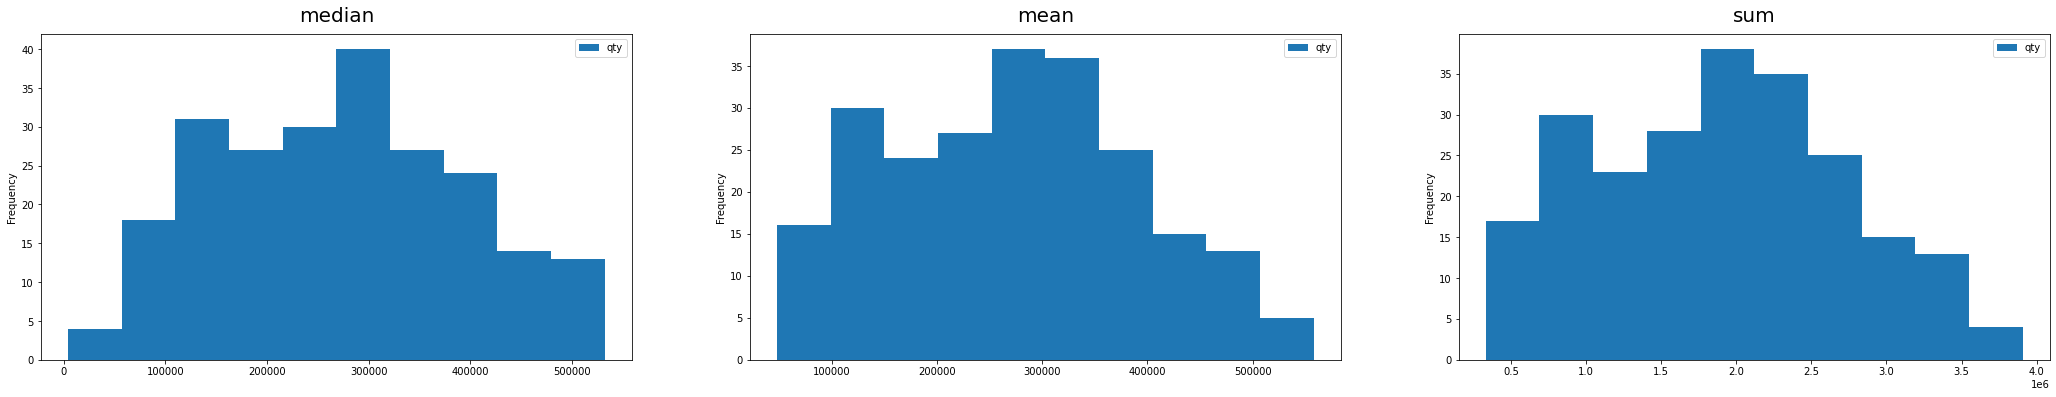

,qty
count,2.280000e+02
mean,1.891049e+06
std,8.332900e+05
min,3.326180e+05
25%,1.210822e+06
50%,1.931074e+06
75%,2.480794e+06
max,3.908174e+06


In [8]:
sum_up_median = view_statistics_weekly_median_aggregated.describe()
sum_up_mean = view_statistics_weekly_mean_aggregated.describe()
sum_up_sum = view_statistics_weekly_sum_aggregated.describe()

data_description = sum_up_mean

# multi histagrams for different sum_ups
fig, axes = plt.subplots(ncols=3, figsize=(36,6))

title_fontsize = {'fontsize': 20}
title_padding = 12

axes[0].set_title('median', fontdict=title_fontsize, pad=title_padding)
axes[1].set_title('mean', fontdict=title_fontsize, pad=title_padding)
axes[2].set_title('sum', fontdict=title_fontsize, pad=title_padding)

# remark: examle hist via hist function
#view_statistics_weekly_mean_aggregated.hist(ax= axes[1])

view_statistics_weekly_median_aggregated.plot(kind='hist', ax= axes[0])
view_statistics_weekly_mean_aggregated.plot(kind='hist', ax= axes[1])
view_statistics_weekly_sum_aggregated.plot(kind='hist', ax= axes[2])

plt.show()
sum_up_sum

Винести побудову 3х під-графіків в окрему функцію! Однакову логіку використовують побудова звичайних графіків та гістограм 

Доказ однородності ряду і невеликого разбросу через коефіцієнт варіації V. Ряди вважаються неоднородники, коли коефіцієнт варіації більше 0.33, але в даному випадку значення не дуже перевищує поріг.

In [9]:
V = data_description.loc['std']/data_description.loc['mean']
print('V = ', V.qty)
#sum_up_mean.loc['std']/sum_up_mean.loc['mean']
#sum_up_median.loc['std']/sum_up_median.loc['mean']

V =  0.43998032253127206


Проведення тесту Харкі-Бера для доказу однорідності ряду
skewness - асиметрія даних
kurtosis - ексцес даних

In [10]:
jarque_bera_test_result = sm.stats.stattools.jarque_bera(data)

#stacked_2d_result = np.stack hstack([jarque_bera_test_result])

result_table = SimpleTable([jarque_bera_test_result], [u'The Jarque-Bera test statistic;\t', u'The p-value of the test statistic;\t', u'Estimated skewness of the data;\t', u'Estimated kurtosis of the data;'])

print(result_table)
#stacked_2d_result

The Jarque-Bera test statistic;	 The p-value of the test statistic;	 Estimated skewness of the data;	 Estimated kurtosis of the data;
-------------------------------------------------------------------------------------------------------------------------------------
                    [6.37564983]                        [0.04126152]                     [0.15362804]                    [2.24058264]
-------------------------------------------------------------------------------------------------------------------------------------


Необхідно звернути увагу на значення колонки 'The pvalue of the test statistic'. Воно показує, що 0-гіпотиза про нормальний розподіл відхиляється з малою вирогідністю (0.064). Тобто ряд має нормальний розподіл, отже - однорідний.

Необхідно перевірка ряду на стаціонарність (маючи на увазі, що ряд має тренд - скоріш за все він не є стаціонарним). Для визначення необхідно провести тест Дики-Фулера. Тест Дики-Фулера виявляє в ряді наявність одиничних коренів.

In [11]:
def perform_dickey_fuller_test(series_to_test):
    dickey_fuller_test_result = sm.tsa.adfuller(series_to_test)

    result_table = SimpleTable([[dickey_fuller_test_result[0], dickey_fuller_test_result[1], dickey_fuller_test_result[4]]], ['adf;', 'p-value', 'Critical values'])

    print(result_table)

    if dickey_fuller_test_result[0] > dickey_fuller_test_result[4]['5%']: 
        print('одиничні корені присутні - ряд не стаціонарний')
    else:
        print('одиничні корені відсутні - ряд стаціонарний')

    #return result_table

In [12]:
perform_dickey_fuller_test(data)

        adf;             p-value                                       Critical values                                 
-----------------------------------------------------------------------------------------------------------------------
-1.4104263262477141 0.5772675254173756 {'1%': -3.460154163751041, '5%': -2.874648939216792, '10%': -2.5737567259151044}
-----------------------------------------------------------------------------------------------------------------------
одиничні корені присутні - ряд не стаціонарний


Результати тесту показують - що ряд не є стаціонарним. При тому при будь якому критичному значенні 1, 5 або 10 відсотків.\
Необхідно знайти порядок ряду. Порядок ряду означає вираховувати різницю ряду із самим собою за вказаним зміщенням. Зміщенням має бути період ряду (від 1 до n). Виоаховувати різницю і тестувати на стаціонарність необхідно до того моменту, поки ряд не стане стаціонарним.

In [13]:
data_stationary = data.diff(periods=1).dropna()
perform_dickey_fuller_test(data_stationary)


       adf;               p-value                                        Critical values                                 
-------------------------------------------------------------------------------------------------------------------------
-9.841917980491436 4.728630997867942e-17 {'1%': -3.460154163751041, '5%': -2.874648939216792, '10%': -2.5737567259151044}
-------------------------------------------------------------------------------------------------------------------------
одиничні корені відсутні - ряд стаціонарний


Також впевнитись в стаціонарності ряду можна розбивши його на декілька частин і перевірити їх математичне очікування. Високе значення говорить про те, що ряд є стаціонарним

In [14]:
statistics_len = len(data_stationary.index)
round_up_index = int(statistics_len/2+1)
pivot_element = data_stationary.index[round_up_index]

series_after_pivot = sm.stats.DescrStatsW(data_stationary[pivot_element:])
series_before_pivot = sm.stats.DescrStatsW(data_stationary[:pivot_element])

print('p-value', sm.stats.CompareMeans(series_after_pivot, series_before_pivot).ttest_ind()[1])

p-value [0.62560265]


Побудуємо графік, щоб і візуально впевнитись в тому, що ряд дійсно стаціонарний

<AxesSubplot:xlabel='date'>

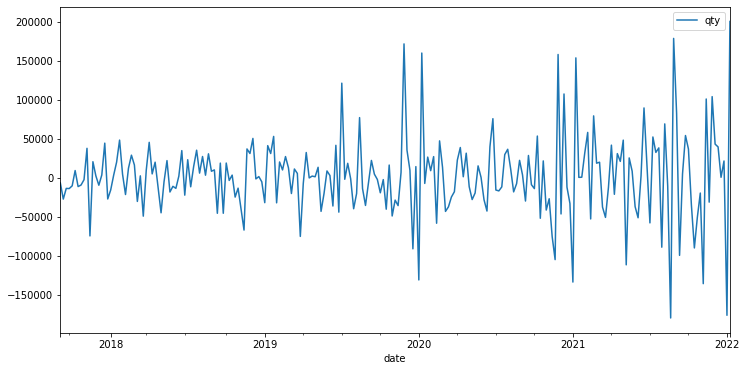

In [15]:
plotly_df(data_stationary, title="views")
data_stationary.plot(figsize=(12,6))

Побудова моделі часового ряду.

Використаємо модель ARIMA(p,d,q)\
* p - порядок компоненти AR (авторегресії)
* d - порядок інтегрованого ряду. З минулих кроків встановлено як 1
* q - порядок компоненти MA (ковзаного середнього)

Для визначення порядку p - будується графік PACF\
Для визначення порядку q - будується графік ACF

c:\python virtual envs\time series\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



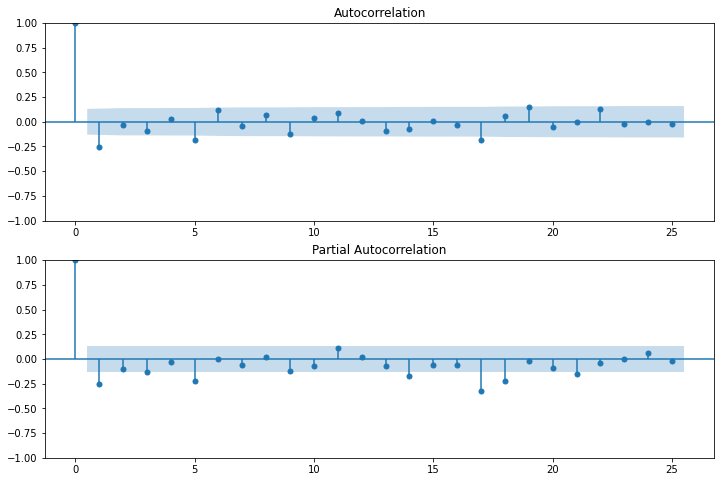

In [16]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data_stationary.values.squeeze(), lags=25, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data_stationary, lags=25, ax=ax2)

Для обох порядків p та q значення - 1. Так як ці значення сильно відрізняються від 0.\
\
Будуємо модель ARIMA для частини ряду. Остаток ряду буде використовуватись для крос-валідації, та оцінки якості моделі.

                               SARIMAX Results                                
Dep. Variable:                    qty   No. Observations:                  196
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2347.283
Date:                Tue, 22 Feb 2022   AIC                           4700.567
Time:                        22:50:40   BIC                           4710.386
Sample:                    09-03-2017   HQIC                          4704.542
                         - 05-30-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6596      0.076      8.720      0.000       0.511       0.808
ma.L1         -0.9110      0.060    -15.292      0.000      -1.028      -0.794
sigma2      1.797e+09   1.77e-12   1.01e+21      0.0

<AxesSubplot:xlabel='date'>

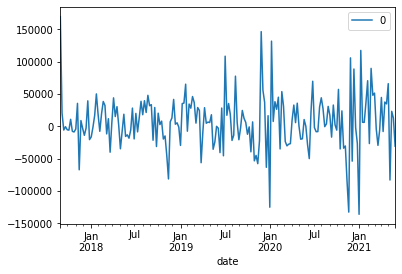

In [17]:
date_to = '2021-06-01'
views_first_part = data[:date_to]
model = ARIMA(views_first_part, order=(1,1,1))
model_fit = model.fit()

print(model_fit.summary())

residuals = DataFrame(model_fit.resid)
residuals.plot()
#plt.show()


In [18]:
q_test = sm.tsa.stattools.acf(model_fit.resid, qstat=True) #resid, зберігає залишки моделі, qstat=True, означає, що застосовуємо тест до коефіціентів.
q_test_data_frame = DataFrame({'Q-stat':q_test[1], 'p-value':q_test[2]})

print(q_test_data_frame)

       Q-stat   p-value
0    0.822887  0.364337
1    2.619751  0.269854
2    6.784799  0.079083
3    6.919835  0.140186
4   11.530868  0.041813
5   20.000843  0.002768
6   20.046336  0.005470
7   20.743557  0.007861
8   21.219694  0.011710
9   21.260663  0.019348
10  22.930945  0.018076
11  22.939087  0.028248
12  25.492442  0.019872
13  33.780945  0.002220
14  35.973130  0.001784
15  37.300623  0.001902
16  41.871480  0.000700
17  42.500163  0.000941
18  42.724513  0.001414
19  42.763453  0.002197
20  44.497906  0.002015
21  45.438678  0.002334


Визначення коефіцієнту детермінації R<sup>2</sup>. Дає зрозуміти, який відсоток спостережень описує дана модель. 

<AxesSubplot:xlabel='date'>

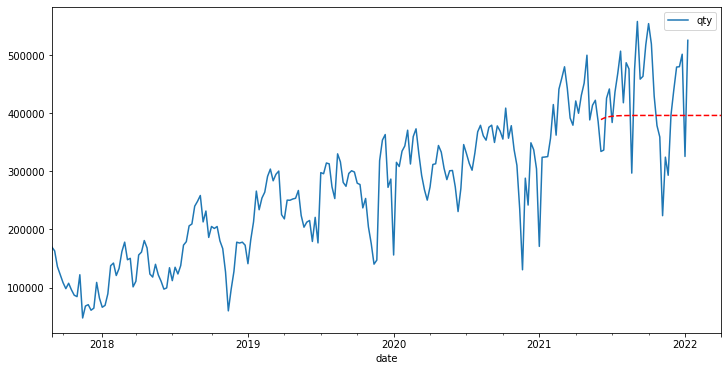

In [19]:
# resets date_to if runs several times in a row
if date_to == '2022-03-31':
    date_to = '2021-06-01'

date_from, date_to = date_to, '2022-03-31'
pred = model_fit.predict(date_from, date_to, typ='levels')

trn = data[date_from:]
#r2 = r2_score(trn, pred[1:32])

#print('R^2: %1.2f' % r2)

data.plot(figsize=(12,6))
pred.plot(style='r--')

#plotly_df(pred, title="views prediction")
#trn.plot()